# Classification: Sparse Variational Approximation for Non-Conjugate Likelihoods with Optim's L-BFGS

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/ApproximateGPs.jl/blob/master/examples/b-classification/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/ApproximateGPs.jl/dev/examples/b-classification/).*

This example demonstrates how to carry out non-conjugate Gaussian process
inference using the stochastic variational Gaussian process (SVGP) model. For
a basic introduction to the functionality of this library, please refer to the
User Guide.

## Setup

In [1]:
using ApproximateGPs
using ParameterHandling
using Zygote
using Distributions
using LinearAlgebra
using Optim

using Plots
default(; legend=:outertopright, size=(700, 400))

using Random
Random.seed!(1234);

## Generate some training data

For our binary classification model, we will use the standard approach of a
latent GP with a Bernoulli likelihood. This results in a generative model that
we can use to produce some training data.

First, we define the underlying latent GP
$$
f \sim \mathcal{GP}(0, k(\cdot, \cdot'))
$$
and sample a function `f`.

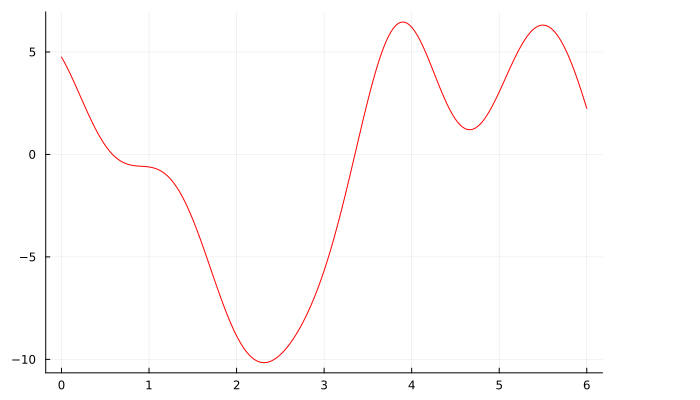

In [2]:
k_true = [30.0, 1.5]
kernel_true = k_true[1] * (SqExponentialKernel() ∘ ScaleTransform(k_true[2]))

jitter = 1e-8  # for numeric stability
lgp = LatentGP(GP(kernel_true), BernoulliLikelihood(), jitter)
x_true = 0:0.02:6
f_true, y_true = rand(lgp(x_true))

plot(x_true, f_true; seriescolor="red", label="")  # Plot the sampled function

Then, the output of this sampled function is pushed through a logistic sigmoid
`μ = σ(f)` to constrain the output to `[0, 1]`.

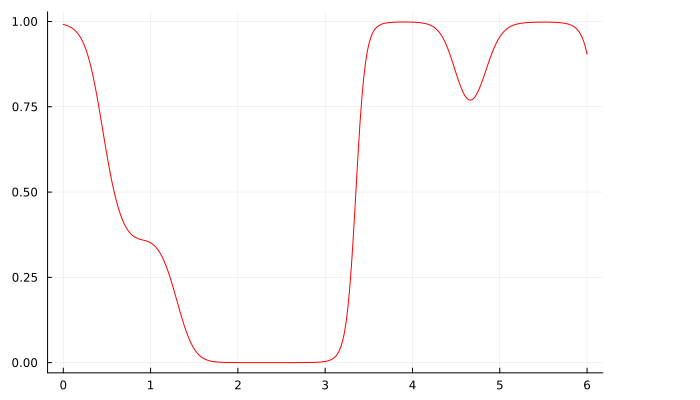

In [3]:
μ = mean.(lgp.lik.(f_true))
plot(x_true, μ; seriescolor="red", label="")

Finally, the outputs `y` of the process are sampled from a Bernoulli
distribution with mean `μ`. We're only interested in the outputs at a subset
of inputs `x`, so we first pick some random input locations and then find the
corresponding values for `y`.

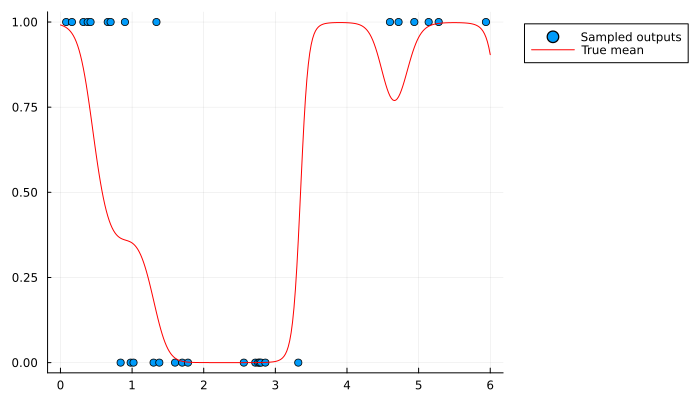

In [4]:
N = 30  # The number of training points
mask = sample(1:length(x_true), N; replace=false, ordered=true)  # Subsample some input locations
x, y = x_true[mask], y_true[mask]

scatter(x, y; label="Sampled outputs")
plot!(x_true, mean.(lgp.lik.(f_true)); seriescolor="red", label="True mean")

## Creating an SVGP

Now that we have some data sampled from a generative model, we can try to recover the
true generative function with an SVGP classification model.

For this, we shall use a mixture of
[ParameterHandling.jl](https://github.com/invenia/ParameterHandling.jl) to
deal with our constrained parameters and
[Optim.jl](https://julianlsolvers.github.io/Optim.jl/stable/) to perform
optimimisation.

The required parameters for the SVGP are - the kernel hyperparameters `k`, the
inducing inputs `z` and the mean and covariance of the variational
distribution `q`; given by `m` and `A` respectively. ParameterHandling
provides an elegant way to deal with the constraints on these parameters,
since `k` must be positive and `A` must be positive definite. For more
details, see the
[ParameterHandling.jl](https://github.com/invenia/ParameterHandling.jl)
readme.

Initialise the parameters

In [5]:
M = 15  # number of inducing points
raw_initial_params = (
    k=(var=positive(rand()), precision=positive(rand())),
    z=bounded.(range(0.1, 5.9; length=M), 0.0, 6.0),  # constrain z to simplify optimisation
    m=zeros(M),
    A=positive_definite(Matrix{Float64}(I, M, M)),
);

`flatten` takes the `NamedTuple` of parameters and returns a flat vector of
`Float64` - along with a function `unflatten` to reconstruct the `NamedTuple`
from a flat vector. `value` takes each parameter in the `NamedTuple` and
applies the necessary transformation to return the constrained value which can
then be used to construct the SVGP model. `unpack` therefore takes a flat,
unconstrained `Vector{Float64}` and returns a `NamedTuple` of constrained
parameter values.

In [6]:
flat_init_params, unflatten = ParameterHandling.flatten(raw_initial_params)
unpack = ParameterHandling.value ∘ unflatten;

Now, we define a function to build everything needed for an SVGP model from
the constrained parameters. The two necessary components are the `LatentGP`
which we are trying to approximate and the
`SparseVariationalApproximation` struct. This struct takes as arguments
the inducing points `fz`, and the variational posterior distribution `q`.
These elements can then be passed to the loss function (the `elbo`) along with
the data `x` and `y`.

In [7]:
lik = BernoulliLikelihood()
jitter = 1e-3  # added to aid numerical stability

function build_SVGP(params::NamedTuple)
    kernel = params.k.var * (SqExponentialKernel() ∘ ScaleTransform(params.k.precision))
    f = LatentGP(GP(kernel), lik, jitter)
    q = MvNormal(params.m, params.A)
    fz = f(params.z).fx
    return SparseVariationalApproximation(fz, q), f
end

function loss(params::NamedTuple)
    svgp, f = build_SVGP(params)
    fx = f(x)
    return -elbo(svgp, fx, y)
end;

Optimise the parameters using LBFGS.

In [8]:
opt = optimize(
    loss ∘ unpack,
    θ -> only(Zygote.gradient(loss ∘ unpack, θ)),
    flat_init_params,
    LBFGS(;
        alphaguess=Optim.LineSearches.InitialStatic(; scaled=true),
        linesearch=Optim.LineSearches.BackTracking(),
    ),
    Optim.Options(; iterations=4_000);
    inplace=false,
)

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.204873e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.17e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.99e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.53e-12 ≰ 0.0e+00
    |g(x)|                 = 2.46e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   50  (vs limit Inf)
    Iterations:    4000
    f(x) calls:    4429
    ∇f(x) calls:   4001


Finally, build the optimised SVGP model, and sample some functions to see if
they are close to the true function.

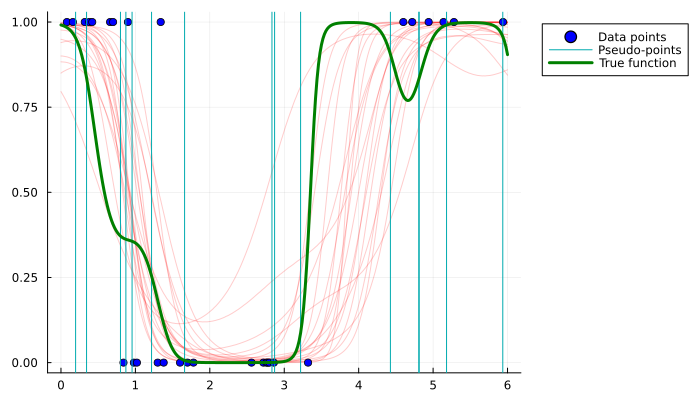

In [9]:
final_params = unpack(opt.minimizer)

svgp_opt, f_opt = build_SVGP(final_params)
post_opt = posterior(svgp_opt)
l_post_opt = LatentGP(post_opt, BernoulliLikelihood(), jitter)

post_f_samples = rand(l_post_opt.f(x_true, 1e-6), 20)
post_μ_samples = mean.(l_post_opt.lik.(post_f_samples))

plt = plot(x_true, post_μ_samples; seriescolor="red", linealpha=0.2, label="")
scatter!(plt, x, y; seriescolor="blue", label="Data points")
vline!(final_params.z; label="Pseudo-points")
plot!(
    x_true, mean.(lgp.lik.(f_true)); seriescolor="green", linewidth=3, label="True function"
)

<hr />
<h6>Package and system information</h6>
<details>
<summary>Package information (click to expand)</summary>
<pre>
      Status &#96;~/work/ApproximateGPs.jl/ApproximateGPs.jl/examples/b-classification/Project.toml&#96;
  &#91;298c2ebc&#93; ApproximateGPs v0.4.4 &#96;/home/runner/work/ApproximateGPs.jl/ApproximateGPs.jl#04dfafc&#96;
  &#91;31c24e10&#93; Distributions v0.25.86
  &#91;98b081ad&#93; Literate v2.14.0
  &#91;429524aa&#93; Optim v1.7.4
  &#91;2412ca09&#93; ParameterHandling v0.4.6
  &#91;91a5bcdd&#93; Plots v1.38.8
  &#91;e88e6eb3&#93; Zygote v0.6.59
  &#91;37e2e46d&#93; LinearAlgebra
  &#91;9a3f8284&#93; Random
</pre>
To reproduce this notebook's package environment, you can
<a href="./Manifest.toml">
download the full Manifest.toml</a>.
</details>
<details>
<summary>System information (click to expand)</summary>
<pre>
Julia Version 1.6.7
Commit 3b76b25b64 &#40;2022-07-19 15:11 UTC&#41;
Platform Info:
  OS: Linux &#40;x86_64-pc-linux-gnu&#41;
  CPU: Intel&#40;R&#41; Xeon&#40;R&#41; CPU E5-2673 v4 @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 &#40;ORCJIT, broadwell&#41;
Environment:
  JULIA_DEBUG &#61; Documenter
  JULIA_LOAD_PATH &#61; :/home/runner/.julia/packages/JuliaGPsDocs/fsJ6N/src
</pre>
</details>

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*